Dataset: Mini Daily Dialog - Use train.csv and test.csv file for the assignment.
Note: Data trimming is not allowed in this question.

Dataset description: The dataset is a sample of widely used DailyDialog dataset for dialogue-act classification task.

Task: Dialogue-act Classification: 

For a given dialogue students need to develop a program to predict act of utterance at time T with the help of previous X utterances as context.

1. Visualize dialogue corpus and show stats of the train and test file. [2 Marks]

2. Implement a program using just LSTM and linear layers to predict act of utterance at time T considering previous X utterances’ context. [8 Marks]
Note: Students need to propose an architecture for this.

3. Now, show plots for accuracy and weighted F1 scores for X = {0,1,2,3,4} [10 Marks]

4. Does the performance of the model increase with increase in X? Justify. [5 Marks]

Expected deliverables of the assignment 

- For every question within each part, visualize the learning using the following plots:
- Training Loss vs Number of Epochs
- Validation Loss vs Number of Epochs
- Plots showing convergence over different values of X
- Save the models in pickles. Students will be asked to reproduce results using saved models only.

In [4]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report

In [6]:
from google.colab import drive
drive.mount('/content/drive')
import nltk
nltk.download('punkt')
nltk.download('stopwords')
 
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

Mounted at /content/drive
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [8]:
folder_path = "/content/drive/MyDrive/DL_A2"
train_file = folder_path + '/train.csv' 
test_file = folder_path + '/test.csv'

In [9]:
train_data = pd.read_csv(train_file, header=0, names=["utterance", "act"])
test_data = pd.read_csv(test_file, header=0, names=["utterance", "act"])

# Part 1: EDA

## 1.1. Visualisation

In [10]:
train_data.shape, test_data.shape

((5090, 2), (722, 2))

In [11]:
train_data.head(10)

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2
5,I suggest a walk over to the gym where we can...,3
6,That's a good idea . I hear Mary and Sally of...,4
7,"Sounds great to me ! If they are willing , we...",1
8,Good.Let ' s go now .,3
9,All right .,4


In [12]:
test_data.sample(10)

,utterance,act
566,"Hey , Karen . Look like you got some sun this ...",1
541,"It is ? Oh , that's nice .",2
480,Could you lend your bike to me for several day...,3
315,I'm ready .,4
270,When can we expect you for dinner ? Can you co...,3
139,I don't have an aspirin . Perhaps you should ...,3
670,"On my first trip I went to Tokyo , and on my ...",1
349,Maybe he is trying to find a job . When he fi...,1
664,It's too late .,4
44,"Hey , Ann . You don't have a pen , do you ?",3


In [13]:
train_data.groupby("act").count()

,utterance
act,
1,2859
2,1497
3,426
4,308


In [14]:
test_data.groupby("act").count()

,utterance
act,
1,363
2,217
3,83
4,59


In [15]:
train_data.shape, test_data.shape

((5090, 2), (722, 2))

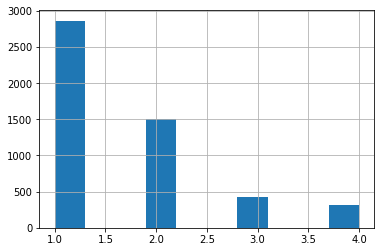

In [16]:
train_data["act"].hist()

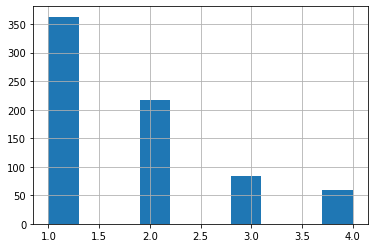

In [17]:
test_data.act.hist()

## 1.2. Data Cleaning

In [18]:
def remove_stop(strings, stop_list):
    classed= [s for s in strings if s not in stop_list]
    return classed

def normalize(text):
    return " ".join(text)

In [19]:
ytrain = np.array(train_data.act).reshape(-1,1)
ytest  = np.array(test_data.act).reshape(-1,1)

In [20]:
y_encoder = OneHotEncoder().fit(np.array(train_data.act).reshape(-1,1))
ytrain_encoded = y_encoder.transform(np.array(train_data.act).reshape(-1,1)).toarray()
ytest_encoded  = y_encoder.transform(np.array(test_data.act).reshape(-1,1)).toarray()

In [21]:
train_data["all_lower"]= train_data.utterance.map(lambda x: x.lower())
test_data["all_lower"]= test_data.utterance.map(lambda x: x.lower())

In [22]:
train_data["tokenized"]= train_data.all_lower.map(word_tokenize)
test_data["tokenized"]= test_data.all_lower.map(word_tokenize)

In [23]:
stop = stopwords.words("english")
stop_punc = list(set(punctuation))+ stop

In [24]:
train_data["refine"]= train_data.tokenized.map(lambda df: remove_stop(df, stop_punc))
test_data["refine"]= test_data.tokenized.map(lambda df: remove_stop(df, stop_punc))

In [25]:
stemmer= PorterStemmer()

train_data["stemmed"]= train_data.refine.map(lambda xs: [stemmer.stem(x) for x in xs])
train_data["normalized"]= train_data.stemmed.apply(normalize)

test_data["stemmed"]= test_data.refine.map(lambda xs: [stemmer.stem(x) for x in xs])
test_data["normalized"]= test_data.stemmed.apply(normalize)

In [26]:
train_data.normalized

0                                  say jim go beer dinner
1                              know tempt realli good fit
2                                      mean help us relax
3       realli think n't make us fat act silli rememb ...
4            guess right.but shall n't feel like sit home
                              ...                        
5085                             tom helen got marri last
5086                       know heart tom ’ father ’ agre
5087                                     invit attend wed
5088              ’ great although father ’ agre tom went
5089                                            move love
Name: normalized, Length: 5090, dtype: object

In [27]:
tokenizer= Tokenizer()
tokenizer.fit_on_texts(train_data.normalized)

In [28]:
tokenized_train = tokenizer.texts_to_sequences(train_data.normalized)
tokenized_test = tokenizer.texts_to_sequences(test_data.normalized)

In [29]:
tokenizer.word_index.keys().__len__()

3675

In [30]:
train_padded = pad_sequences(tokenized_train, maxlen=10, padding = "pre")
test_padded = pad_sequences(tokenized_test, maxlen=10, padding = "pre")

train_padded.shape, test_padded.shape

((5090, 10), (722, 10))

In [31]:
def transform_x(data, tokenizer, x):
    output_shape= [data.shape[0], x, tokenizer.word_index.keys().__len__()]
    results= np.zeros(output_shape)
    
    for i in range(data.shape[0]):
        for ii in range(x):
            results[i, ii, data[i,ii]-1]= 1
            
    return results

# Part 2: NN - LSTM + Linear Layers

## 2.1: Implement LSTM

In [32]:
class LSTMLinear(object):
    def __init__(self):
        self.loss= tf.keras.losses.CategoricalCrossentropy()
        self.metrics= tf.keras.metrics.AUC()
        self.optimizer= tf.keras.optimizers.Adam()        

    def get_model(self, input_dim, output_shape, steps):
        self.input_dim = input_dim
        self.output_shape = output_shape
        self.steps = steps
        
        model = self.build_model()
        model = self.compile_model(model)
        
        return model
        
    def build_model(self):
        
        input_layer= tf.keras.layers.Input(shape=(self.steps, self.input_dim))
        x = tf.keras.layers.LSTM(units=self.steps+1)(input_layer)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Dense(self.output_shape*2)(x)
        x = tf.keras.layers.Dense(self.output_shape)(x)
        output= tf.keras.activations.softmax(x, axis= 1)
 
        model= tf.keras.Model(inputs= [input_layer], outputs= [output])
        
        return model
    
    def compile_model(self, model):

        model.compile(optimizer= self.optimizer, loss= self.loss, metrics= [self.metrics])
        
        return model

In [33]:
model_dir = LSTMLinear()

# Part 3: Train LSTM for different steps

## Part 3.1: Train for X=0


In [34]:
Xtrain0 = train_padded.copy()
Xtest0 = test_padded.copy()

Xtrain0 = Xtrain0[:, np.newaxis, :]
Xtest0 = Xtest0[:, np.newaxis, :]

Xtrain0.shape , Xtest0.shape

((5090, 1, 10), (722, 1, 10))

In [35]:
steps = Xtrain0.shape[1]
dim = Xtrain0.shape[2]
output_shape = ytrain_encoded.shape[1]
epochs = 10

In [36]:
dim

10

In [37]:
model = model_dir.get_model(input_dim= dim,
                      output_shape= output_shape,
                      steps= 1)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 10)]           0         
                                                                 
 lstm (LSTM)                 (None, 2)                 104       
                                                                 
 batch_normalization (BatchN  (None, 2)                8         
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 8)                 24        
                                                                 
 dense_1 (Dense)             (None, 4)                 36        
                                                                 
 tf.nn.softmax (TFOpLambda)  (None, 4)                 0         
                                                             

In [38]:
history = model.fit(Xtrain0, ytrain_encoded, validation_split= 0.2, epochs= epochs)

Epoch 1/10
128/128 [==============================] - 4s 10ms/step - loss: 1.3752 - auc: 0.6108 - val_loss: 1.1976 - val_auc: 0.7886
Epoch 2/10
128/128 [==============================] - 1s 4ms/step - loss: 1.1747 - auc: 0.7643 - val_loss: 1.0760 - val_auc: 0.8034
Epoch 3/10
128/128 [==============================] - 1s 4ms/step - loss: 1.0935 - auc: 0.7821 - val_loss: 1.0262 - val_auc: 0.8095
Epoch 4/10
128/128 [==============================] - 1s 4ms/step - loss: 1.0741 - auc: 0.7861 - val_loss: 1.0155 - val_auc: 0.8094
Epoch 5/10
128/128 [==============================] - 1s 4ms/step - loss: 1.0708 - auc: 0.7869 - val_loss: 1.0141 - val_auc: 0.8121
Epoch 6/10
128/128 [==============================] - 1s 4ms/step - loss: 1.0694 - auc: 0.7880 - val_loss: 1.0129 - val_auc: 0.8132
Epoch 7/10
128/128 [==============================] - 0s 4ms/step - loss: 1.0695 - auc: 0.7883 - val_loss: 1.0124 - val_auc: 0.8128
Epoch 8/10
128/128 [==============================] - 1s 4ms/step - loss: 1

### Training Curves

In [39]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

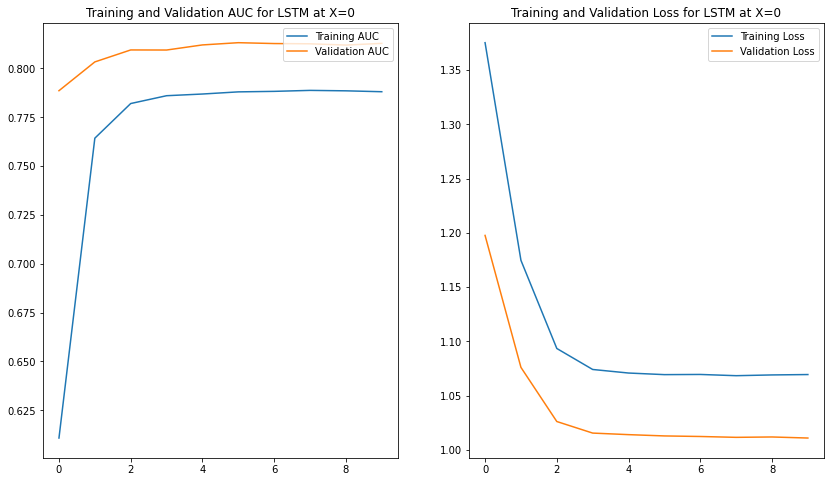

In [40]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC for LSTM at X=0')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LSTM at X=0')
plt.show()

### Training evaluation

In [41]:
prediction_train = y_encoder.inverse_transform(model.predict(Xtrain0))
print(classification_report(train_data.act, prediction_train))

              precision    recall  f1-score   support

           1       0.56      1.00      0.72      2859
           2       0.00      0.00      0.00      1497
           3       0.00      0.00      0.00       426
           4       0.00      0.00      0.00       308

    accuracy                           0.56      5090
   macro avg       0.14      0.25      0.18      5090
weighted avg       0.32      0.56      0.40      5090



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing Evaluation

In [42]:
prediction_test= y_encoder.inverse_transform(model.predict(Xtest0))
print(classification_report(test_data.act, prediction_test))

              precision    recall  f1-score   support

           1       0.50      1.00      0.67       363
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00        83
           4       0.00      0.00      0.00        59

    accuracy                           0.50       722
   macro avg       0.13      0.25      0.17       722
weighted avg       0.25      0.50      0.34       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
model.save("X0")
!zip -r /content/X0.zip /content/X0
from google.colab import files
files.download('/content/X0.zip')

INFO:tensorflow:Assets written to: X0/assets


INFO:tensorflow:Assets written to: X0/assets


  adding: content/X0/ (stored 0%)
  adding: content/X0/assets/ (stored 0%)
  adding: content/X0/keras_metadata.pb (deflated 88%)
  adding: content/X0/variables/ (stored 0%)
  adding: content/X0/variables/variables.data-00000-of-00001 (deflated 70%)
  adding: content/X0/variables/variables.index (deflated 65%)
  adding: content/X0/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 3.2: Train for X=1


In [44]:
Xtrain1 = transform_x(train_padded, tokenizer, x=1)
Xtest1 = transform_x(test_padded, tokenizer, x=1)

Xtrain1.shape , Xtest1.shape

((5090, 1, 3675), (722, 1, 3675))

In [45]:
steps = Xtrain1.shape[1]
dim = Xtrain1.shape[2]
output_shape = ytrain_encoded.shape[1]
epochs = 10

In [46]:
model = model_dir.get_model(input_dim= dim,
                             output_shape= output_shape,
                             steps=steps)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 3675)]         0         
                                                                 
 lstm_1 (LSTM)               (None, 2)                 29424     
                                                                 
 batch_normalization_1 (Batc  (None, 2)                8         
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 24        
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 tf.nn.softmax_1 (TFOpLambda  (None, 4)                0         
 )                                                         

In [47]:
history = model.fit(Xtrain1, ytrain_encoded, validation_split= 0.2, epochs= epochs)

Epoch 1/10
128/128 [==============================] - 4s 11ms/step - loss: 1.1137 - auc: 0.7859 - val_loss: 1.0167 - val_auc: 0.8116
Epoch 2/10
128/128 [==============================] - 1s 5ms/step - loss: 1.0458 - auc: 0.7941 - val_loss: 1.0107 - val_auc: 0.8120
Epoch 3/10
128/128 [==============================] - 1s 5ms/step - loss: 1.0306 - auc: 0.8008 - val_loss: 1.0105 - val_auc: 0.8115
Epoch 4/10
128/128 [==============================] - 1s 5ms/step - loss: 1.0229 - auc: 0.8017 - val_loss: 1.0143 - val_auc: 0.8117
Epoch 5/10
128/128 [==============================] - 1s 5ms/step - loss: 1.0172 - auc: 0.8049 - val_loss: 1.0173 - val_auc: 0.8110
Epoch 6/10
128/128 [==============================] - 1s 6ms/step - loss: 1.0121 - auc: 0.8058 - val_loss: 1.0312 - val_auc: 0.8076
Epoch 7/10
128/128 [==============================] - 1s 5ms/step - loss: 1.0085 - auc: 0.8074 - val_loss: 1.0226 - val_auc: 0.8061
Epoch 8/10
128/128 [==============================] - 1s 6ms/step - loss: 1

### Training Curves

In [48]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

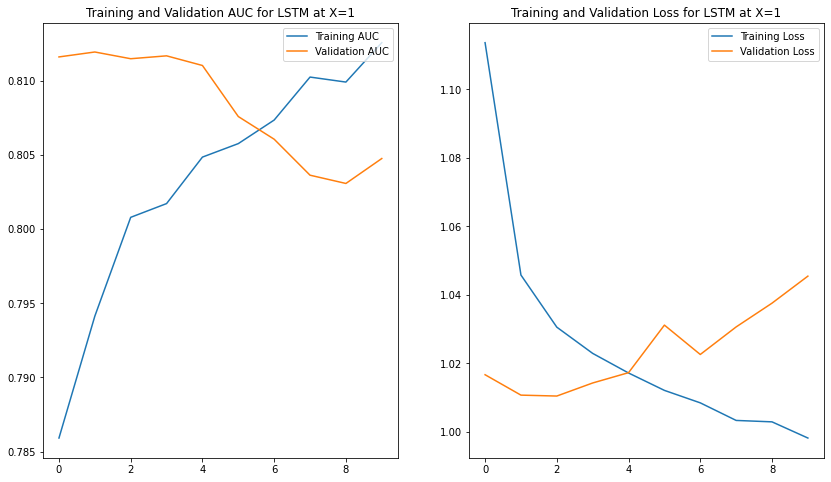

In [49]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC for LSTM at X=1')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LSTM at X=1')
plt.show()

### Training evaluation

In [50]:
prediction_train = y_encoder.inverse_transform(model.predict(Xtrain1))
print(classification_report(train_data.act, prediction_train))

              precision    recall  f1-score   support

           1       0.57      0.99      0.72      2859
           2       0.74      0.02      0.05      1497
           3       0.58      0.10      0.18       426
           4       0.00      0.00      0.00       308

    accuracy                           0.57      5090
   macro avg       0.47      0.28      0.24      5090
weighted avg       0.59      0.57      0.43      5090



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Testing Evaluation

In [51]:
prediction_test = y_encoder.inverse_transform(model.predict(Xtest1))
print(classification_report(test_data.act, prediction_test))

              precision    recall  f1-score   support

           1       0.50      0.99      0.66       363
           2       0.00      0.00      0.00       217
           3       0.00      0.00      0.00        83
           4       0.00      0.00      0.00        59

    accuracy                           0.50       722
   macro avg       0.12      0.25      0.17       722
weighted avg       0.25      0.50      0.33       722



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
model.save("X1")
!zip -r /content/X1.zip /content/X1
from google.colab import files
files.download('/content/X1.zip')

INFO:tensorflow:Assets written to: X1/assets


INFO:tensorflow:Assets written to: X1/assets


  adding: content/X1/ (stored 0%)
  adding: content/X1/assets/ (stored 0%)
  adding: content/X1/keras_metadata.pb (deflated 88%)
  adding: content/X1/variables/ (stored 0%)
  adding: content/X1/variables/variables.data-00000-of-00001 (deflated 64%)
  adding: content/X1/variables/variables.index (deflated 64%)
  adding: content/X1/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 3.3: Train for X=2


In [53]:
Xtrain2 = transform_x(train_padded, tokenizer, x=2)
Xtest2 = transform_x(test_padded, tokenizer, x=2)

Xtrain2.shape , Xtest2.shape

((5090, 2, 3675), (722, 2, 3675))

In [54]:
steps = Xtrain2.shape[1]
dim = Xtrain2.shape[2]
output_shape = ytrain_encoded.shape[1]
epochs = 10

In [55]:
model = model_dir.get_model(input_dim= dim,
                      output_shape= output_shape,
                      steps= steps)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 2, 3675)]         0         
                                                                 
 lstm_2 (LSTM)               (None, 3)                 44148     
                                                                 
 batch_normalization_2 (Batc  (None, 3)                12        
 hNormalization)                                                 
                                                                 
 dense_4 (Dense)             (None, 8)                 32        
                                                                 
 dense_5 (Dense)             (None, 4)                 36        
                                                                 
 tf.nn.softmax_2 (TFOpLambda  (None, 4)                0         
 )                                                         

In [56]:
history = model.fit(Xtrain2, ytrain_encoded, validation_split= 0.2, epochs= epochs)

Epoch 1/10
128/128 [==============================] - 4s 12ms/step - loss: 1.1021 - auc: 0.7836 - val_loss: 1.0114 - val_auc: 0.8150
Epoch 2/10
128/128 [==============================] - 1s 8ms/step - loss: 1.0214 - auc: 0.8041 - val_loss: 1.0069 - val_auc: 0.8149
Epoch 3/10
128/128 [==============================] - 1s 7ms/step - loss: 0.9950 - auc: 0.8114 - val_loss: 1.0200 - val_auc: 0.8131
Epoch 4/10
128/128 [==============================] - 1s 7ms/step - loss: 0.9791 - auc: 0.8162 - val_loss: 1.0440 - val_auc: 0.8106
Epoch 5/10
128/128 [==============================] - 1s 7ms/step - loss: 0.9652 - auc: 0.8230 - val_loss: 1.1510 - val_auc: 0.7413
Epoch 6/10
128/128 [==============================] - 1s 7ms/step - loss: 0.9573 - auc: 0.8260 - val_loss: 1.1300 - val_auc: 0.7935
Epoch 7/10
128/128 [==============================] - 1s 7ms/step - loss: 0.9505 - auc: 0.8277 - val_loss: 1.1754 - val_auc: 0.7637
Epoch 8/10
128/128 [==============================] - 1s 7ms/step - loss: 0

### Training Curves

In [57]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

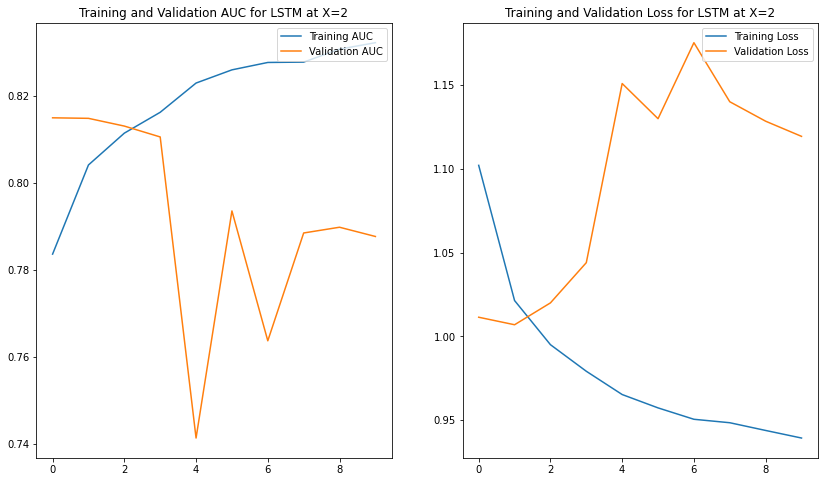

In [58]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC for LSTM at X=2')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LSTM at X=2')
plt.show()

### Training evaluation

In [59]:
prediction_train = y_encoder.inverse_transform(model.predict(Xtrain2))
print(classification_report(train_data.act, prediction_train))

              precision    recall  f1-score   support

           1       0.58      0.99      0.73      2859
           2       0.90      0.05      0.09      1497
           3       0.73      0.19      0.30       426
           4       0.85      0.07      0.13       308

    accuracy                           0.59      5090
   macro avg       0.76      0.33      0.31      5090
weighted avg       0.70      0.59      0.47      5090



### Testing Evaluation

In [60]:
prediction_test = y_encoder.inverse_transform(model.predict(Xtest2))
print(classification_report(test_data.act, prediction_test))

              precision    recall  f1-score   support

           1       0.50      0.96      0.66       363
           2       0.43      0.01      0.03       217
           3       0.14      0.02      0.04        83
           4       0.00      0.00      0.00        59

    accuracy                           0.49       722
   macro avg       0.27      0.25      0.18       722
weighted avg       0.40      0.49      0.34       722



In [61]:
model.save("X2")
!zip -r /content/X2.zip /content/X2
from google.colab import files
files.download('/content/X2.zip')

INFO:tensorflow:Assets written to: X2/assets


INFO:tensorflow:Assets written to: X2/assets


  adding: content/X2/ (stored 0%)
  adding: content/X2/assets/ (stored 0%)
  adding: content/X2/keras_metadata.pb (deflated 88%)
  adding: content/X2/variables/ (stored 0%)
  adding: content/X2/variables/variables.data-00000-of-00001 (deflated 58%)
  adding: content/X2/variables/variables.index (deflated 63%)
  adding: content/X2/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 3.4: Train for X=3


In [62]:
Xtrain3 = transform_x(train_padded, tokenizer, x=3)
Xtest3 = transform_x(test_padded, tokenizer, x=3)

Xtrain3.shape , Xtest3.shape

((5090, 3, 3675), (722, 3, 3675))

In [63]:
steps = Xtrain3.shape[1]
dim = Xtrain3.shape[2]
output_shape = ytrain_encoded.shape[1]
epochs = 10

In [64]:
model = model_dir.get_model(input_dim= dim,
                      output_shape= output_shape,
                      steps= steps)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 3, 3675)]         0         
                                                                 
 lstm_3 (LSTM)               (None, 4)                 58880     
                                                                 
 batch_normalization_3 (Batc  (None, 4)                16        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 8)                 40        
                                                                 
 dense_7 (Dense)             (None, 4)                 36        
                                                                 
 tf.nn.softmax_3 (TFOpLambda  (None, 4)                0         
 )                                                         

In [65]:
history = model.fit(Xtrain3, ytrain_encoded, validation_split= 0.2, epochs= epochs)

Epoch 1/10
128/128 [==============================] - 5s 16ms/step - loss: 1.0971 - auc: 0.7854 - val_loss: 1.0167 - val_auc: 0.8164
Epoch 2/10
128/128 [==============================] - 1s 9ms/step - loss: 0.9990 - auc: 0.8132 - val_loss: 1.0043 - val_auc: 0.8161
Epoch 3/10
128/128 [==============================] - 1s 9ms/step - loss: 0.9625 - auc: 0.8260 - val_loss: 1.0047 - val_auc: 0.8136
Epoch 4/10
128/128 [==============================] - 1s 10ms/step - loss: 0.9404 - auc: 0.8326 - val_loss: 1.0596 - val_auc: 0.7598
Epoch 5/10
128/128 [==============================] - 1s 9ms/step - loss: 0.9247 - auc: 0.8380 - val_loss: 1.0947 - val_auc: 0.7556
Epoch 6/10
128/128 [==============================] - 1s 9ms/step - loss: 0.9160 - auc: 0.8406 - val_loss: 1.1028 - val_auc: 0.7519
Epoch 7/10
128/128 [==============================] - 1s 9ms/step - loss: 0.9040 - auc: 0.8451 - val_loss: 1.0917 - val_auc: 0.7936
Epoch 8/10
128/128 [==============================] - 1s 9ms/step - loss: 

### Training Curves

In [66]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

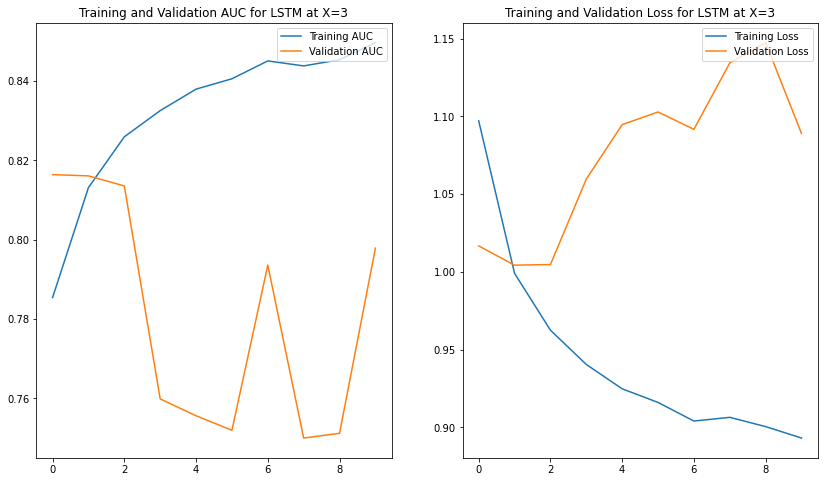

In [67]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC for LSTM at X=3')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LSTM at X=3')
plt.show()

### Training evaluation

In [68]:
prediction_train = y_encoder.inverse_transform(model.predict(Xtrain3))
print(classification_report(train_data.act, prediction_train))

              precision    recall  f1-score   support

           1       0.59      0.99      0.74      2859
           2       0.78      0.08      0.14      1497
           3       0.83      0.24      0.37       426
           4       0.93      0.08      0.15       308

    accuracy                           0.60      5090
   macro avg       0.78      0.35      0.35      5090
weighted avg       0.68      0.60      0.49      5090



### Testing Evaluation

In [69]:
prediction_test = y_encoder.inverse_transform(model.predict(Xtest3))
print(classification_report(test_data.act, prediction_test))

              precision    recall  f1-score   support

           1       0.50      0.94      0.65       363
           2       0.31      0.02      0.04       217
           3       0.07      0.01      0.02        83
           4       0.00      0.00      0.00        59

    accuracy                           0.48       722
   macro avg       0.22      0.24      0.18       722
weighted avg       0.35      0.48      0.34       722



In [70]:
model.save("X3")
!zip -r /content/X3.zip /content/X3
from google.colab import files
files.download('/content/X3.zip')

INFO:tensorflow:Assets written to: X3/assets


INFO:tensorflow:Assets written to: X3/assets


  adding: content/X3/ (stored 0%)
  adding: content/X3/assets/ (stored 0%)
  adding: content/X3/keras_metadata.pb (deflated 88%)
  adding: content/X3/variables/ (stored 0%)
  adding: content/X3/variables/variables.data-00000-of-00001 (deflated 53%)
  adding: content/X3/variables/variables.index (deflated 64%)
  adding: content/X3/saved_model.pb (deflated 89%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Part 3.5: Train for X=4


In [71]:
Xtrain4 = transform_x(train_padded, tokenizer, x=4)
Xtest4 = transform_x(test_padded, tokenizer, x=4)

Xtrain4.shape , Xtest4.shape

((5090, 4, 3675), (722, 4, 3675))

In [72]:
steps = Xtrain4.shape[1]
dim = Xtrain4.shape[2]
output_shape = ytrain_encoded.shape[1]

epochs = 10

In [73]:
model = model_dir.get_model(input_dim= dim,
                      output_shape= output_shape,
                      steps= steps)
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 4, 3675)]         0         
                                                                 
 lstm_4 (LSTM)               (None, 5)                 73620     
                                                                 
 batch_normalization_4 (Batc  (None, 5)                20        
 hNormalization)                                                 
                                                                 
 dense_8 (Dense)             (None, 8)                 48        
                                                                 
 dense_9 (Dense)             (None, 4)                 36        
                                                                 
 tf.nn.softmax_4 (TFOpLambda  (None, 4)                0         
 )                                                         

In [74]:
history = model.fit(Xtrain4, ytrain_encoded, validation_split= 0.2, epochs= epochs)

Epoch 1/10
128/128 [==============================] - 6s 23ms/step - loss: 1.0806 - auc: 0.7903 - val_loss: 1.0103 - val_auc: 0.8203
Epoch 2/10
128/128 [==============================] - 1s 12ms/step - loss: 0.9677 - auc: 0.8233 - val_loss: 1.0016 - val_auc: 0.8198
Epoch 3/10
128/128 [==============================] - 2s 13ms/step - loss: 0.9140 - auc: 0.8411 - val_loss: 1.0264 - val_auc: 0.8162
Epoch 4/10
128/128 [==============================] - 2s 13ms/step - loss: 0.8767 - auc: 0.8554 - val_loss: 1.0667 - val_auc: 0.8084
Epoch 5/10
128/128 [==============================] - 1s 11ms/step - loss: 0.8627 - auc: 0.8572 - val_loss: 1.1155 - val_auc: 0.8001
Epoch 6/10
128/128 [==============================] - 2s 13ms/step - loss: 0.8556 - auc: 0.8601 - val_loss: 1.2750 - val_auc: 0.7956
Epoch 7/10
128/128 [==============================] - 2s 12ms/step - loss: 0.8469 - auc: 0.8622 - val_loss: 1.1899 - val_auc: 0.7846
Epoch 8/10
128/128 [==============================] - 2s 12ms/step - 

### Training Curves

In [75]:
auc = history.history['auc']
val_auc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

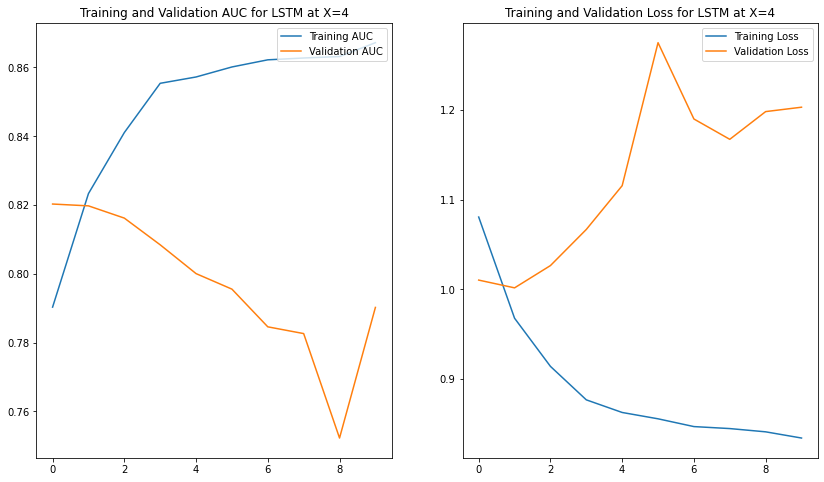

In [76]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, auc, label='Training AUC')
plt.plot(epochs_range, val_auc, label='Validation AUC')
plt.legend(loc='upper right')
plt.title('Training and Validation AUC for LSTM at X=4')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss for LSTM at X=4')
plt.show()

### Training evaluation

In [77]:
prediction_train = y_encoder.inverse_transform(model.predict(Xtrain4))
print(classification_report(train_data.act, prediction_train))

              precision    recall  f1-score   support

           1       0.60      0.98      0.74      2859
           2       0.87      0.09      0.17      1497
           3       0.77      0.31      0.45       426
           4       0.85      0.11      0.20       308

    accuracy                           0.61      5090
   macro avg       0.77      0.38      0.39      5090
weighted avg       0.71      0.61      0.52      5090



### Testing Evaluation

In [78]:
prediction_test = y_encoder.inverse_transform(model.predict(Xtest4))
print(classification_report(test_data.act, prediction_test))

              precision    recall  f1-score   support

           1       0.49      0.93      0.64       363
           2       0.00      0.00      0.00       217
           3       0.13      0.04      0.06        83
           4       0.00      0.00      0.00        59

    accuracy                           0.47       722
   macro avg       0.16      0.24      0.18       722
weighted avg       0.26      0.47      0.33       722



In [79]:
model.save("X4")
!zip -r /content/X4.zip /content/X4
from google.colab import files
files.download('/content/X4.zip')

INFO:tensorflow:Assets written to: X4/assets


INFO:tensorflow:Assets written to: X4/assets


  adding: content/X4/ (stored 0%)
  adding: content/X4/assets/ (stored 0%)
  adding: content/X4/keras_metadata.pb (deflated 88%)
  adding: content/X4/variables/ (stored 0%)
  adding: content/X4/variables/variables.data-00000-of-00001 (deflated 48%)
  adding: content/X4/variables/variables.index (deflated 64%)
  adding: content/X4/saved_model.pb (deflated 90%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Part 4: Comparison

- We see that the model performance does not increase linearly with X. 
- Beyond X=2, the model starts overfitting. 
- This may be because of use of only Linear Layers in LSTM. 
- To increase accuracy, we need to add Bidirectional LSTM to increase model context for learning.